### HW8- ozone formation

#### Creating a function that takes NOx and RH mixing ratios and outputs maximum O3, and an "ozone isopleth plot":

In [71]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

In [72]:
# Constants (given inputs):
temp = 298 #kelvin
pres = 1e5 #Pascals
Rgas = 8.314 #J/(mol-K)
avo = 6.022e23 

# rate constants, units are cm3/(molec-s)
k1 = 26.3e-12
k2 = 7.7e-12
k3 = 8.1e-12
k4 = 1.1e-11
k5 = 2.9e-12
k6 = 5.2e-12
k7 = 0.015 # units s-1
k8 = 1.9e-14

# unit conversions
airden = (pres*avo) / (Rgas*temp*1e6) #molec/cm3
Cnox = nox*1e-9*airden
Crh = rh*1e-9*airden
CPHOx = PHOx*1e-12*airden  #molec/(cm3-s)
ppbfac = 1e9/airden

In [73]:
# The ozone function from class
# u[0] u[1] u[2] u[3] u[4] u[5] u[6]
# NO   NO2   OH  RO2  HO2   O3   RH

def myfun(t, u):
    f = np.zeros(7)
    f[0] = -k2 * u[3] * u[0] + k7 * u[1] - k8 * u[5] * u[0] - k3 * u[4] * u[0]
    f[1] = k2 * u[3] * u[0] + k3 * u[4] * u[0] + k8 * u[5] * u[0] - k7 * u[1] - k4 * u[2] * u[1]
    f[2] = -k1 * u[6] * u[2] + k3 * u[4] * u[0] - k4 * u[2] * u[1] + CPHOx
    f[3] = k1 * u[6] * u[2] - k2 * u[3] * u[0] - k6 * u[3] * u[4]
    f[4] = k2 * u[3] * u[0] - k3 * u[4] * u[0] - 2 * k5 * u[4]**2 - k6 * u[3] * u[4]
    f[5] = k7 * u[1] - k8 * u[5] * u[0]
    f[6] = -k1 * u[6] * u[2]
    return f


In [74]:
#timestep
Dt = 2 #seconds
t0 = 0
tmax = 12*3600
t = np.arange(t0, t0+tmax, Dt)
NN = np.shape(t)
N = NN[0]

In [76]:
# Function to calculate max O3
def calculate_max_o3(nox, rh):
    Cnox = nox * 1e-9 * airden
    Crh = rh * 1e-9 * airden
    CPHOx = PHOx * 1e-12 * airden  # molec/(cm^3-s)
    
    # Initial conditions
    # NOx = NO + NO2
    u0 = np.zeros(7)
    u0[0] = Cnox * (2 / 3)
    u0[1] = Cnox * (1 / 3)
    u0[2] = 0
    u0[3] = 0
    u0[4] = 0
    u0[5] = 0
    u0[6] = Crh  # molec / cm3 of RH hydrocarbon

    # Solve ODE
    sol = solve_ivp(myfun, [t0, tmax], u0, method='LSODA', t_eval=np.linspace(t0, tmax, 500))
    
    # Calculate maximum O3 in ppb
    max_o3 = np.max(sol.y[5] * ppbfac)
    return max_o3
    

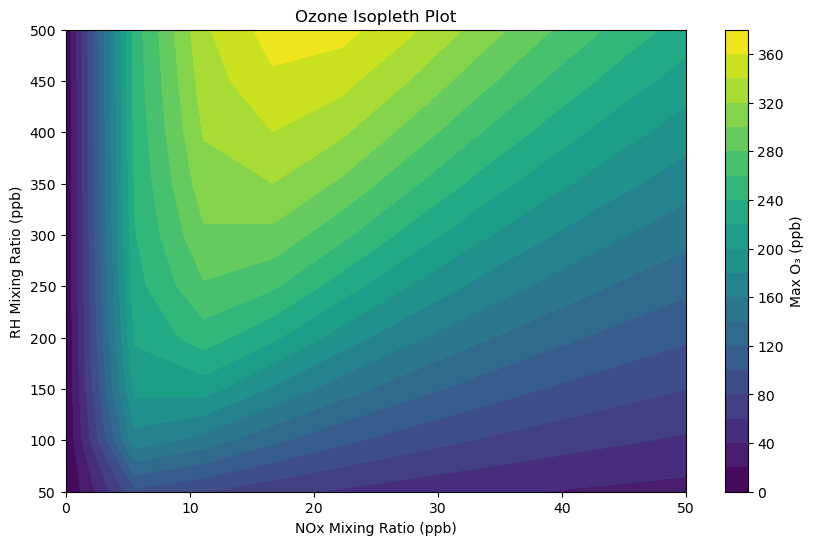

In [77]:
# Create grid of NOx and RH values
nox_values = np.linspace(0, 50, 10)  # NOx in ppbv
rh_values = np.linspace(50, 500, 10)  # RH in ppbv
NOX, RH = np.meshgrid(nox_values, rh_values)

# Compute maximum O3 for each pair of NOx and RH
O3_max = np.zeros_like(NOX)
for i in range(NOX.shape[0]):
    for j in range(NOX.shape[1]):
        O3_max[i, j] = calculate_max_o3(NOX[i, j], RH[i, j])

# Ploting the isopleth as a contour plot
plt.figure(figsize=(10, 6))
contour = plt.contourf(NOX, RH, O3_max, levels=20, cmap='viridis')
plt.colorbar(contour, label='Max O₃ (ppb)')
plt.xlabel('NOx Mixing Ratio (ppb)')
plt.ylabel('RH Mixing Ratio (ppb)')
plt.title('Ozone Isopleth Plot')
plt.show()
